# Overview

1. Project Instructions & Prerequisites
2. Learning Objectives
3. Data Preparation
4. Create Categorical Features with TF Feature Columns
5. Create Continuous/Numerical Features with TF Feature Columns
6. Build Deep Learning Regression Model with Sequential API and TF Probability Layers
7. Evaluating Potential Model Biases with Aequitas Toolkit


#  1. Project Instructions & Prerequisites

## Project Instructions

**Context**: EHR data is becoming a key source of real-world evidence (RWE) for the pharmaceutical industry and regulators to [make decisions on clinical trials](https://www.fda.gov/news-events/speeches-fda-officials/breaking-down-barriers-between-clinical-trials-and-clinical-care-incorporating-real-world-evidence). You are a data scientist for an exciting unicorn healthcare startup that has created a groundbreaking diabetes drug that is ready for clinical trial testing. It is a very unique and sensitive drug that requires administering the drug over at least 5-7 days of time in the hospital with frequent monitoring/testing and patient medication adherence training with a mobile application. You have been provided a patient dataset from a client partner and are tasked with building a predictive model that can identify which type of patients the company should focus their efforts testing this drug on. Target patients are people that are likely to be in the hospital for this duration of time and will not incur significant additional costs for administering this drug to the patient and monitoring.  

In order to achieve your goal you must build a regression model that can predict the estimated hospitalization time for a patient and use this to select/filter patients for your study.


**Expected Hospitalization Time Regression Model:** Utilizing a synthetic dataset(denormalized at the line level augmentation) built off of the UCI Diabetes readmission dataset, students will build a regression model that predicts the expected days of hospitalization time and then convert this to a binary prediction of whether to include or exclude that patient from the clinical trial.

This project will demonstrate the importance of building the right data representation at the encounter level, with appropriate filtering and preprocessing/feature engineering of key medical code sets. This project will also require students to analyze and interpret their model for biases across key demographic groups. 

Please see the project rubric online for more details on the areas your project will be evaluated.

### Dataset

Due to healthcare PHI regulations (HIPAA, HITECH), there are limited number of publicly available datasets and some datasets require training and approval. So, for the purpose of this exercise, we are using a dataset from UC Irvine(https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008) that has been modified for this course. Please note that it is limited in its representation of some key features such as diagnosis codes which are usually an unordered list in 835s/837s (the HL7 standard interchange formats used for claims and remits).

**Data Schema**
The dataset reference information can be https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/
. There are two CSVs that provide more details on the fields and some of the mapped values.

## Project Submission 

When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "student_project_submission.ipynb" and save another copy as an HTML file by clicking "File" -> "Download as.."->"html". Include the "utils.py" and "student_utils.py" files in your submission. The student_utils.py should be where you put most of your code that you write and the summary and text explanations should be written inline in the notebook. Once you download these files, compress them into one zip file for submission.

## Prerequisites 

- Intermediate level knowledge of Python
- Basic knowledge of probability and statistics
- Basic knowledge of machine learning concepts
- Installation of Tensorflow 2.0 and other dependencies(conda environment.yml or virtualenv requirements.txt file provided)

## Environment Setup

For step by step instructions on creating your environment, please go to https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/README.md.

# 2.  Learning Objectives

By the end of the project, you will be able to 
   - Use the Tensorflow Dataset API to scalably extract, transform, and load datasets and build datasets aggregated at the line, encounter, and patient data levels(longitudinal)
   - Analyze EHR datasets to check for common issues (data leakage, statistical properties, missing values, high cardinality) by performing exploratory data analysis.
   - Create categorical features from Key Industry Code Sets (ICD, CPT, NDC) and reduce dimensionality for high cardinality features by using embeddings 
   - Create derived features(bucketing, cross-features, embeddings) utilizing Tensorflow feature columns on both continuous and categorical input features
   - SWBAT use the Tensorflow Probability library to train a model that provides uncertainty range predictions that allow for risk adjustment/prioritization and triaging of predictions
   - Analyze and determine biases for a model for key demographic groups by evaluating performance metrics across groups by using the Aequitas framework 


# 3. Data Preparation

In [1]:
# from __future__ import absolute_import, division, print_function, unicode_literals
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.metrics
import aequitas as ae
# Put all of the helper functions in utils
from utils import build_vocab_files, show_group_stats_viz, aggregate_dataset, preprocess_df, df_to_dataset, posterior_mean_field, prior_trainable
pd.set_option('display.max_columns', 500)
# this allows you to make changes and save in student_utils.py and the file is reloaded every time you run a code block
%load_ext autoreload
%autoreload

In [2]:
#OPEN ISSUE ON MAC OSX for TF model training
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Dataset Loading and Schema Review

Load the dataset and view a sample of the dataset along with reviewing the schema reference files to gain a deeper understanding of the dataset. The dataset is located at the following path https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/starter_code/data/final_project_dataset.csv. Also, review the information found in the data schema https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/

In [3]:
dataset_path = "./data/final_project_dataset.csv"
df = pd.read_csv(dataset_path)

## Determine Level of Dataset (Line or Encounter)

**Question 1**: Based off of analysis of the data, what level is this dataset? Is it at the line or encounter level? Are there any key fields besides the encounter_id and patient_nbr fields that we should use to aggregate on? Knowing this information will help inform us what level of aggregation is necessary for future steps and is a step that is often overlooked. 

In [4]:
# Line Test
try:
    assert df.shape[0] > df['encounter_id'].nunique() 
    print('Dataset could be at the line level')
except:
    print('Dataset is not at the line level')
# Encounter Test
try:
    assert df.shape == df['encounter_id'].nunique()
    print('Dataset could be at the encounter level')
except:
    print('Dataset is not at the encounter level')

Dataset could be at the line level
Dataset is not at the encounter level


Student Response:

Dataset is at line level. The main aggregation IDs are encounter_id and patient_nbr.

## Analyze Dataset

**Question 2**: Utilizing the library of your choice (recommend Pandas and Seaborn or matplotlib though), perform exploratory data analysis on the dataset. In particular be sure to address the following questions:  
   - a. Field(s) with high amount of missing/zero values
   - b. Based off the frequency histogram for each numerical field, which numerical field(s) has/have a Gaussian(normal) distribution shape?
   - c. Which field(s) have high cardinality and why (HINT: ndc_code is one feature)
   - d. Please describe the demographic distributions in the dataset for the age and gender fields.
    


**OPTIONAL**: Use the Tensorflow Data Validation and Analysis library to complete. 
- The Tensorflow Data Validation and Analysis library(https://www.tensorflow.org/tfx/data_validation/get_started) is a useful tool for analyzing and summarizing dataset statistics. It is especially useful because it can scale to large datasets that do not fit into memory. 
- Note that there are some bugs that are still being resolved with Chrome v80 and we have moved away from using this for the project. 

In [5]:
ser_null = df.replace(to_replace='?', value=np.nan).isnull().sum()
print('a.) Relative number of missing values:')
ser_null[ser_null > 0].sort_values(ascending=False) / df.shape[0]

a.) Relative number of missing values:


weight                    0.970005
medical_specialty         0.484319
payer_code                0.377831
ndc_code                  0.163585
race                      0.023071
primary_diagnosis_code    0.000230
dtype: float64

In [6]:
print('a.) Total number of missing values:')
ser_null[ser_null > 0].sort_values(ascending=False)

a.) Total number of missing values:


weight                    139122
medical_specialty          69463
payer_code                 54190
ndc_code                   23462
race                        3309
primary_diagnosis_code        33
dtype: int64

b.) Numerical fields analysis:


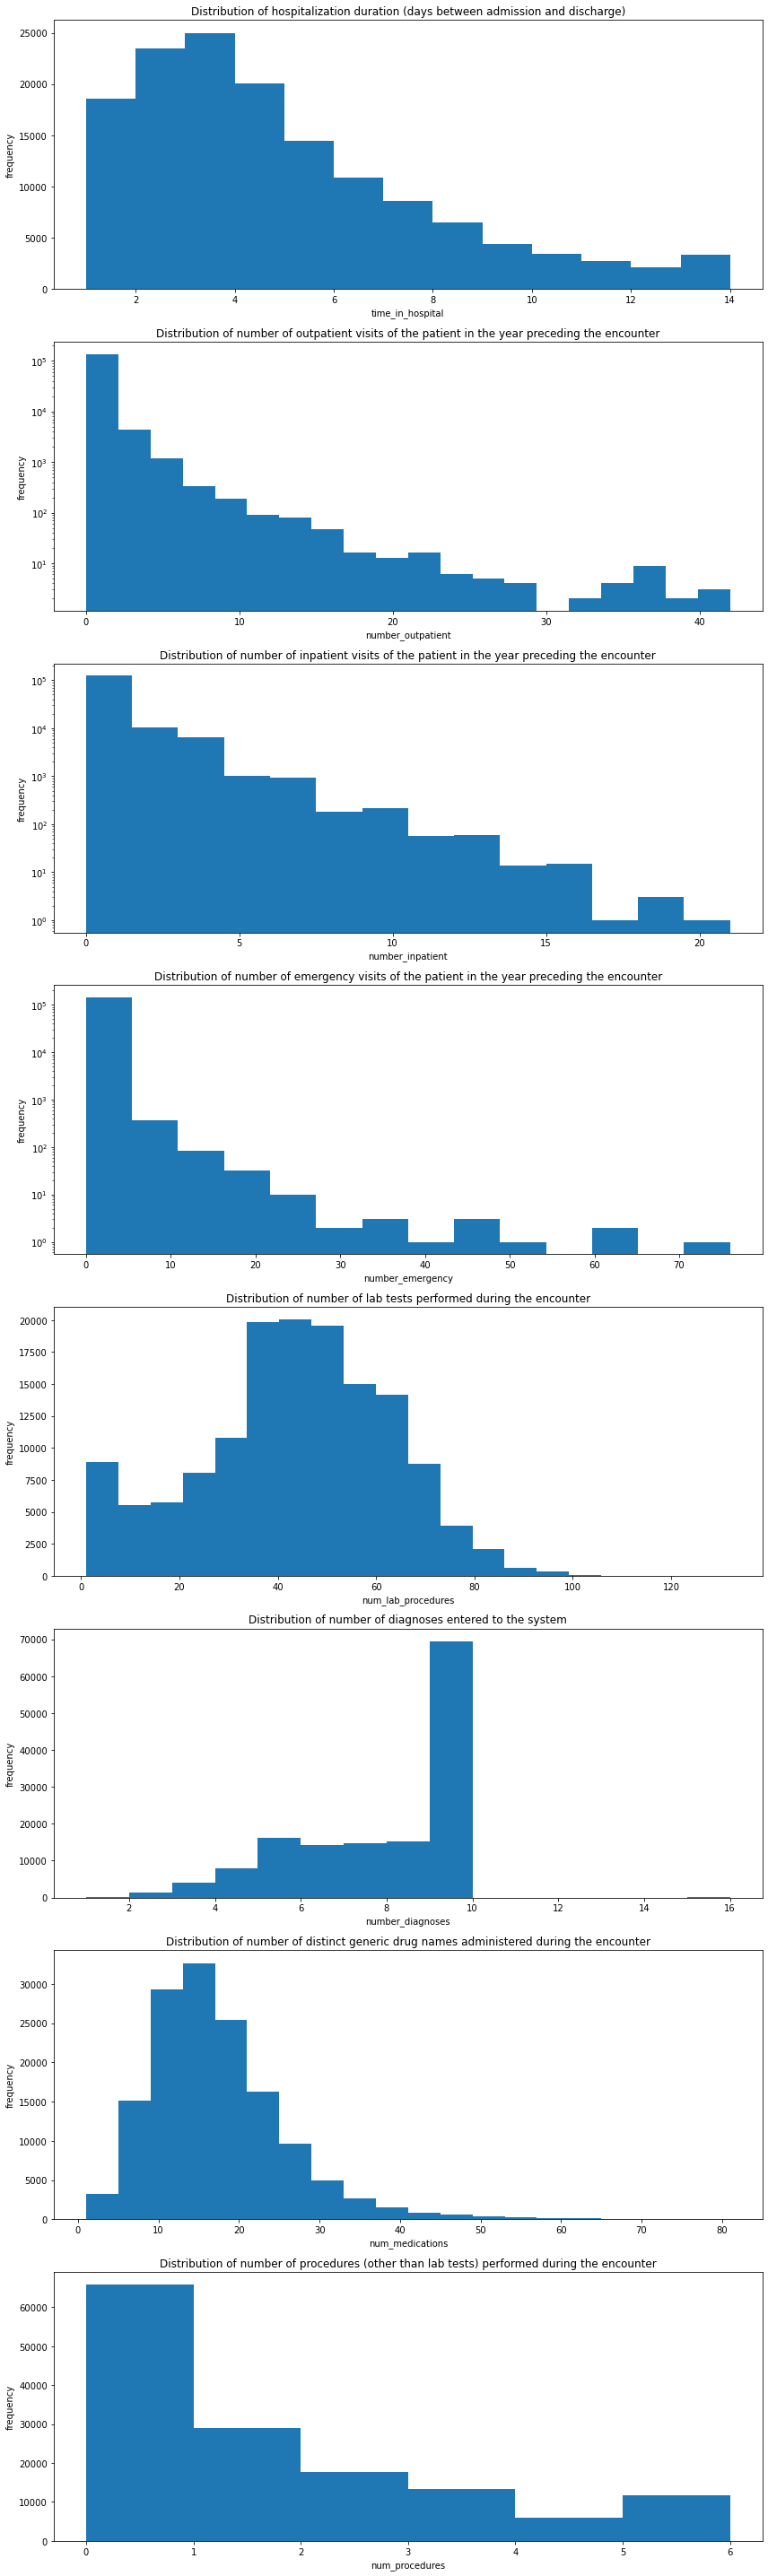

In [7]:
print('b.) Numerical fields analysis:')

cols_numerical = [
    'time_in_hospital', 'number_outpatient', 'number_inpatient',
    'number_emergency', 'num_lab_procedures', 'number_diagnoses',
    'num_medications', 'num_procedures'
]

fig, ax = plt.subplots(len(cols_numerical), figsize=(12, 5*len(cols_numerical)))

i = 0
col = 'time_in_hospital'
ttl = f'Distribution of hospitalization duration (days between admission and discharge)'
df[col].plot.hist(ax=ax[i], title=ttl, bins=13)
ax[i].set_xlabel(col)
ax[i].set_ylabel('frequency')

i = 1
col = 'number_outpatient'
ttl = f'Distribution of number of outpatient visits of the patient in the year preceding the encounter'
df[col].plot.hist(ax=ax[i], title=ttl, bins=20, logy=True)
ax[i].set_xlabel(col)
ax[i].set_ylabel('frequency')

i = 2
col = 'number_inpatient'
ttl = f'Distribution of number of inpatient visits of the patient in the year preceding the encounter'
df[col].plot.hist(ax=ax[i], title=ttl, bins=14, logy=True)
ax[i].set_xlabel(col)
ax[i].set_ylabel('frequency')

i = 3
col = 'number_emergency'
ttl = f'Distribution of number of emergency visits of the patient in the year preceding the encounter'
df[col].plot.hist(ax=ax[i], title=ttl, bins=14, logy=True)
ax[i].set_xlabel(col)
ax[i].set_ylabel('frequency')

i = 4
col = 'num_lab_procedures'
ttl = f'Distribution of number of lab tests performed during the encounter'
df[col].plot.hist(ax=ax[i], title=ttl, bins=20)
ax[i].set_xlabel(col)
ax[i].set_ylabel('frequency')

i = 5
col = 'number_diagnoses'
ttl = f'Distribution of number of diagnoses entered to the system'
df[col].plot.hist(ax=ax[i], title=ttl, bins=15)
ax[i].set_xlabel(col)
ax[i].set_ylabel('frequency')

i = 6
col = 'num_medications'
ttl = f'Distribution of number of distinct generic drug names administered during the encounter'
df[col].plot.hist(ax=ax[i], title=ttl, bins=20)
ax[i].set_xlabel(col)
ax[i].set_ylabel('frequency')

i = 7
col = 'num_procedures'
ttl = f'Distribution of number of procedures (other than lab tests) performed during the encounter'
df[col].plot.hist(ax=ax[i], title=ttl, bins=6)
ax[i].set_xlabel(col)
ax[i].set_ylabel('frequency')

plt.tight_layout()

In [8]:
print('c.) high cardinality analysis:')
ser_nunique = df.nunique()
ser_nunique[ser_nunique>20].sort_values(ascending=False)

c.) high cardinality analysis:


encounter_id                101766
patient_nbr                  71518
other_diagnosis_codes        19374
primary_diagnosis_code         717
ndc_code                       251
num_lab_procedures             118
num_medications                 75
medical_specialty               73
number_outpatient               39
number_emergency                33
discharge_disposition_id        26
number_inpatient                21
dtype: int64

d.) Demographic distribution analysis:


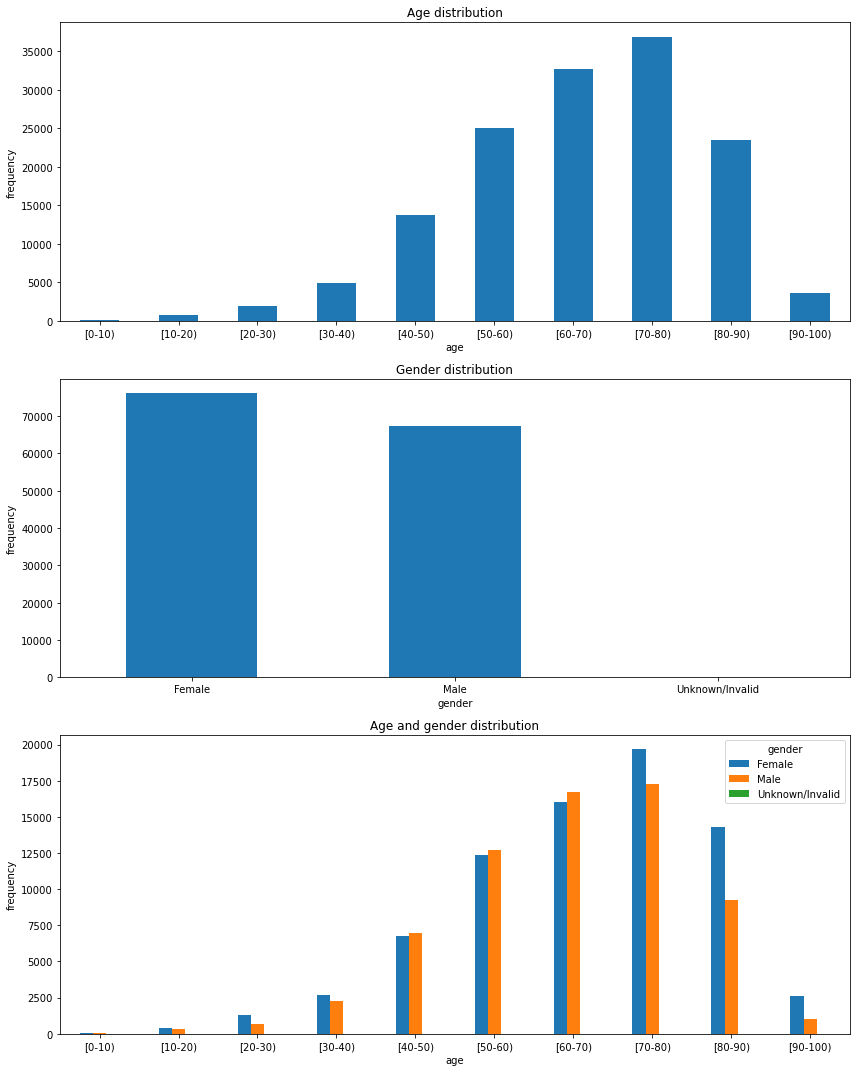

In [9]:
print('d.) Demographic distribution analysis:')
fig, ax = plt.subplots(3, figsize=(12, 15))

ttl = 'Age distribution'
df['age'].value_counts().sort_index().plot.bar(rot=0, ax=ax[0], title=ttl)
ax[0].set_xlabel('age')
ax[0].set_ylabel('frequency')

ttl = 'Gender distribution'
df['gender'].value_counts().sort_index().plot.bar(rot=0, ax=ax[1], title=ttl)
ax[1].set_xlabel('gender')
ax[1].set_ylabel('frequency')

ttl = 'Age and gender distribution'
df.groupby('age')['gender'].value_counts().sort_index().unstack().plot.bar(ax=ax[2], rot=0, title=ttl)
ax[2].set_xlabel('age')
ax[2].set_ylabel('frequency')

plt.tight_layout()

In [10]:
print('d.) relative gender distribution:')
df['gender'].value_counts() / df.shape[0]

d.) relative gender distribution:


Female             0.531187
Male               0.468778
Unknown/Invalid    0.000035
Name: gender, dtype: float64

**Student Response**:

    - a. Fields with high missing values: weight, payer_code, medical_speciality and (maybe) ndc_code (16% missing values)
    - b. The numerical fields with (skewed) Gaussian distribution shapes are: time_in_hospital, num_lab_procedures, num_medications
    - c. Fields with high cardinality are 
        - encounter_id: many encounters
        - patient_nbr: many patients
        - other_diagnosis_codes, primary_diagnosis_code, ndc_code: huge code database (high cardinality)
        - the other listed high cardinalities above are either numeric or have a lot different categories, too
    - d. The demographic distributions of the dataset looks like this:
        - the vast majority of patients are between age 50 - 90 with mode 70 - 80
        - 53% are female 47% are male
        - each age range has about similar cardinality of males/females. The older the patient, the more females are there.

d.) Demographic distribution analysis:


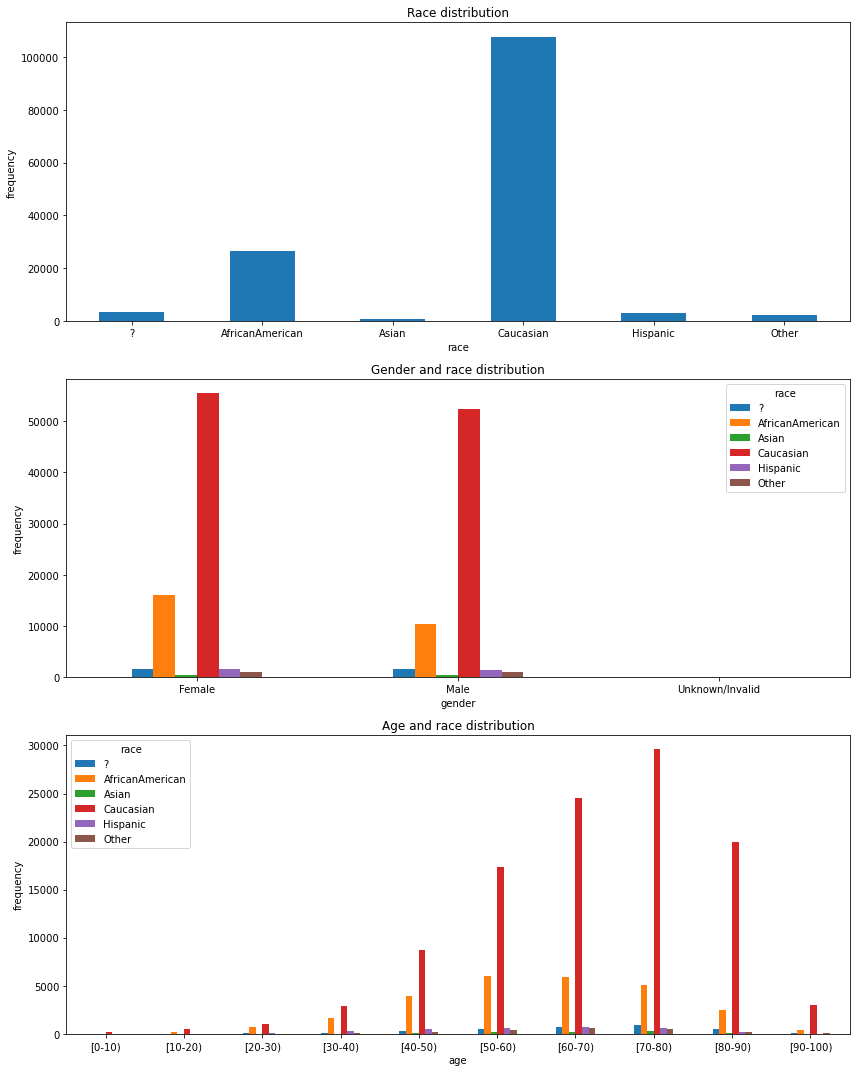

In [11]:
print('d.) Demographic distribution analysis:')
fig, ax = plt.subplots(3, figsize=(12, 15))

ttl = 'Race distribution'
df['race'].value_counts().sort_index().plot.bar(rot=0, ax=ax[0], title=ttl)
ax[0].set_xlabel('race')
ax[0].set_ylabel('frequency')

ttl = 'Gender and race distribution'
df.groupby('gender')['race'].value_counts().sort_index().unstack().plot.bar(ax=ax[1], rot=0, title=ttl)
ax[1].set_xlabel('gender')
ax[1].set_ylabel('frequency')

ttl = 'Age and race distribution'
df.groupby('age')['race'].value_counts().sort_index().unstack().plot.bar(ax=ax[2], rot=0, title=ttl)
ax[2].set_xlabel('age')
ax[2].set_ylabel('frequency')

plt.tight_layout()

In [12]:
######NOTE: The visualization will only display in Chrome browser. ########
# full_data_stats = tfdv.generate_statistics_from_csv(data_location='./data/final_project_dataset.csv') 
# tfdv.visualize_statistics(full_data_stats)

## Reduce Dimensionality of the NDC Code Feature

**Question 3**: NDC codes are a common format to represent the wide variety of drugs that are prescribed for patient care in the United States. The challenge is that there are many codes that map to the same or similar drug. You are provided with the ndc drug lookup file https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/ndc_lookup_table.csv derived from the National Drug Codes List site(https://ndclist.com/). Please use this file to come up with a way to reduce the dimensionality of this field and create a new field in the dataset called "generic_drug_name" in the output dataframe. 

In [13]:
#NDC code lookup file
ndc_code_path = "./medication_lookup_tables/final_ndc_lookup_table"
ndc_code_df = pd.read_csv(ndc_code_path)

In [14]:
from student_utils import reduce_dimension_ndc
reduce_dim_df = reduce_dimension_ndc(df, ndc_code_df)
# Number of unique values should be less for the new output field
assert df['ndc_code'].nunique() > reduce_dim_df['generic_drug_name'].nunique()

In [15]:
print("We were able to reduce the dimension in the ndc_code " +
      f"field from {df['ndc_code'].nunique(dropna=False)} to " +
      f"{reduce_dim_df['generic_drug_name'].nunique(dropna=False)} " +
      "(including nan's).")

We were able to reduce the dimension in the ndc_code field from 252 to 23 (including nan's).


## Select First Encounter for each Patient 

**Question 4**: In order to simplify the aggregation of data for the model, we will only select the first encounter for each patient in the dataset. This is to reduce the risk of data leakage of future patient encounters and to reduce complexity of the data transformation and modeling steps. We will assume that sorting in numerical order on the encounter_id provides the time horizon for determining which encounters come before and after another.

In [16]:
from student_utils import select_first_encounter
first_encounter_df = select_first_encounter(reduce_dim_df)

In [17]:
# unique patients in transformed dataset
unique_patients = first_encounter_df['patient_nbr'].nunique()
print("Number of unique patients:{}".format(unique_patients))

# unique encounters in transformed dataset
unique_encounters = first_encounter_df['encounter_id'].nunique()
print("Number of unique encounters:{}".format(unique_encounters))

original_unique_patient_number = reduce_dim_df['patient_nbr'].nunique()
# number of unique patients should be equal to the number of unique encounters and patients in the final dataset
assert original_unique_patient_number == unique_patients
assert original_unique_patient_number == unique_encounters
print("Tests passed!!")

Number of unique patients:71518
Number of unique encounters:71518
Tests passed!!


## Aggregate Dataset to Right Level for Modeling 

In order to provide a broad scope of the steps and to prevent students from getting stuck with data transformations, we have selected the aggregation columns and provided a function to build the dataset at the appropriate level. The 'aggregate_dataset" function that you can find in the 'utils.py' file can take the preceding dataframe with the 'generic_drug_name' field and transform the data appropriately for the project. 

To make it simpler for students, we are creating dummy columns for each unique generic drug name and adding those as input features to the model. There are other options for data representation but this is out of scope for the time constraints of the course.

In [18]:
exclusion_list = ['generic_drug_name']
grouping_field_list = [c for c in first_encounter_df.columns if c not in exclusion_list]
agg_drug_df, ndc_col_list = aggregate_dataset(
    df=first_encounter_df,
    grouping_field_list=grouping_field_list,
    array_field='generic_drug_name'
)
assert len(agg_drug_df) == agg_drug_df['patient_nbr'].nunique() == agg_drug_df['encounter_id'].nunique()

In [19]:
## we fill missing values of the new OHE ndc code fields, because it makes no sense to leave them as nan values
## nan values only mean the absence of the considered medication
agg_drug_df[ndc_col_list] = agg_drug_df[ndc_col_list].fillna(0)

In [20]:
thresh = 10
val_count_ndc = agg_drug_df[ndc_col_list].sum()
print(f"drop these generic drug name columns with frequency/occurances < {thresh}: \n\t{', '.join([f'{idx} ({val})' for idx, val in val_count_ndc[val_count_ndc<=thresh].items()])}")
agg_drug_df = agg_drug_df.drop(val_count_ndc[val_count_ndc<thresh].index, axis=1)
## update ndc codel list
ndc_col_list = [i for i in ndc_col_list if i not in val_count_ndc[val_count_ndc<thresh].index]

drop these generic drug name columns with frequency/occurances < 10: 
	Glipizide_And_Metformin_Hcl (1.0), Glipizide_And_Metformin_Hydrochloride (6.0), Pioglitazole_And_Metformin_Hydrochloride (1.0)


## Prepare Fields and Cast Dataset 

### Feature Selection

**Question 5**: After you have aggregated the dataset to the right level, we can do feature selection (we will include the ndc_col_list, dummy column features too). In the block below, please select the categorical and numerical features that you will use for the model, so that we can create a dataset subset. 

For the payer_code and weight fields, please provide whether you think we should include/exclude the field in our model and give a justification/rationale for this based off of the statistics of the data. Feel free to use visualizations or summary statistics to support your choice.

Student response:
excluded fields:

    - we exclude the weight field due to 97% missing values 
    - we exclude payer_code (38% missing values). payer_code is not relevant for predicting the hospitalization duration since it only describes the payment method
    - we exclude the discharge_disposition_id since this information is not available for new arrival patients.
    - we exclude other_diagnosis_codes because it has very high cardinality with a lot of unique values that occure only once or a few times

included fields: 

    - medical_speciality has a high missing rate (48%) but we keep it, because it makes sense to replace the missing value with a placeholder. This placeholder might represent cases where it is not relevant to indicate the admitting physician.

we also delete some entries which frequencies are too low. See below (processed_df)

In [21]:
'''
Please update the list to include the features you think are appropriate for the model 
and the field that we will be using to train the model. There are three required demographic features for the model 
and I have inserted a list with them already in the categorical list. 
These will be required for later steps when analyzing data splits and model biases.
'''
required_demo_col_list = ['race', 'gender', 'age']
student_categorical_col_list = [
    'admission_type_id', 'admission_source_id', 'medical_specialty',
    'primary_diagnosis_code', 'max_glu_serum',
    'A1Cresult', 'change', 'readmitted'
] + required_demo_col_list + ndc_col_list
student_numerical_col_list = [
    'number_outpatient', 'number_inpatient', 'number_emergency',
    'num_lab_procedures', 'number_diagnoses', 'num_medications',
    'num_procedures'
]
PREDICTOR_FIELD = 'time_in_hospital'

In [22]:
def select_model_features(df, categorical_col_list, numerical_col_list, PREDICTOR_FIELD, grouping_key='patient_nbr'):
    selected_col_list = [grouping_key] + [PREDICTOR_FIELD] + categorical_col_list + numerical_col_list   
    return agg_drug_df[selected_col_list]

In [23]:
selected_features_df = select_model_features(
    df=agg_drug_df,
    categorical_col_list=student_categorical_col_list,
    numerical_col_list=student_numerical_col_list,
    PREDICTOR_FIELD=PREDICTOR_FIELD,
    grouping_key='patient_nbr'
)

### Preprocess Dataset - Casting and Imputing  

We will cast and impute the dataset before splitting so that we do not have to repeat these steps across the splits in the next step. For imputing, there can be deeper analysis into which features to impute and how to impute but for the sake of time, we are taking a general strategy of imputing zero for only numerical features. 

OPTIONAL: What are some potential issues with this approach? Can you recommend a better way and also implement it?

In [24]:
processed_df = preprocess_df(
    selected_features_df,
    student_categorical_col_list, 
    student_numerical_col_list,
    PREDICTOR_FIELD,
    categorical_impute_value='nan',
    numerical_impute_value=0
)

/mnt/pool1/workspace/ml/nd320-c1-emr-data-starter/6final_project/starter_code/utils.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[predictor] = df[predictor].astype(float)
/mnt/pool1/workspace/ml/nd320-c1-emr-data-starter/6final_project/starter_code/utils.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[c] = cast_df(df, c, d_type=str)
/mnt/pool1/workspace/ml/nd320-c1-emr-data-starter/6final_project/starter_code/utils.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

In [25]:
# delete rows with gender != {male, female}
thresh = 10
val_count_gender = processed_df['gender'].value_counts(dropna=False)
print(f"delete all gender entries (rows) that have a frequency <= {thresh}: " +
      f"{', '.join([f'{idx} ({val})' for idx, val in val_count_gender[val_count_gender<=thresh].items()])}")
processed_df = processed_df[processed_df['gender'].isin(val_count_gender[val_count_gender>thresh].index)]

## reassign ids of admission_type_id column that have too low number of entries:
val_count_atype = processed_df['admission_type_id'].value_counts(dropna=False)
print(f"consider all admission_type_id's with frequency <= {thresh} as invalid and assign them to id 8 (Not Mapped): " +
      f"{', '.join([f'{idx} ({val})' for idx, val in val_count_atype[val_count_atype<=thresh].items()])}")
processed_df.loc[processed_df['admission_type_id'].isin(val_count_atype[val_count_atype<=thresh].index), 'admission_type_id'] = '8'

## reassign ids of admission_source_id column that have too low number of entries:
val_count_asource = processed_df['admission_source_id'].value_counts(dropna=False)
print(f"consider all admission_source_id's with frequency <= {thresh} as invalid and assign them to id 20 (Not Mapped): " +
      f"{', '.join([f'{idx} ({val})' for idx, val in val_count_asource[val_count_asource<=thresh].items()])}")
processed_df.loc[processed_df['admission_source_id'].isin(val_count_asource[val_count_asource<=thresh].index), 'admission_source_id'] = '20'

val_count_medspecialty = processed_df['medical_specialty'].value_counts(dropna=False)
print(f"consider all medical_specialty entries with frequency <= {thresh} as invalid and assign them to id ? (missing value placeholder):\n\t" +
      f"{', '.join([f'{idx} ({val})' for idx, val in val_count_medspecialty[val_count_medspecialty<=thresh].items()])}")
processed_df.loc[processed_df['medical_specialty'].isin(val_count_medspecialty[val_count_medspecialty<=thresh].index), 'medical_specialty'] = '?'

val_count_pdiagcode = processed_df['primary_diagnosis_code'].value_counts(dropna=False)
print(f"consider all primary_diagnosis_code entries with frequency <= {thresh} as invalid and assign them to id ? (missing value placeholder):\n\t" +
      f"{', '.join([f'{idx} ({val})' for idx, val in val_count_pdiagcode[val_count_pdiagcode<=thresh].items()])}")
processed_df.loc[processed_df['primary_diagnosis_code'].isin(val_count_pdiagcode[val_count_pdiagcode<=thresh].index), 'primary_diagnosis_code'] = '?'

delete all gender entries (rows) that have a frequency <= 10: Unknown/Invalid (3)
consider all admission_type_id's with frequency <= 10 as invalid and assign them to id 8 (Not Mapped): 4 (9)
consider all admission_source_id's with frequency <= 10 as invalid and assign them to id 20 (Not Mapped): 10 (7), 22 (4), 14 (2), 25 (2), 13 (1), 11 (1)
consider all medical_specialty entries with frequency <= 10 as invalid and assign them to id ? (missing value placeholder):
	Rheumatology (10), Surgery-Maxillofacial (10), OutreachServices (9), Surgery-Colon&Rectal (9), PhysicianNotFound (8), Anesthesiology (7), Pediatrics-Neurology (7), Cardiology-Pediatric (7), Pathology (7), Endocrinology-Metabolism (7), Surgery-Pediatric (6), AllergyandImmunology (6), Psychiatry-Child/Adolescent (6), Pediatrics-Pulmonology (6), DCPTEAM (4), Dentistry (4), Pediatrics-EmergencyMedicine (3), Pediatrics-Hematology-Oncology (3), SportsMedicine (1), Proctology (1), Speech (1), Dermatology (1), Resident (1), Surgery-P

/home/ud/miniconda3/envs/py38ml/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [26]:
processed_df['race'].value_counts(dropna=False)

Caucasian          53491
AfricanAmerican    12887
?                   1946
Hispanic            1517
Other               1177
Asian                497
Name: race, dtype: int64

In [27]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
processed_df[student_numerical_col_list] = scale.fit_transform(processed_df[student_numerical_col_list])

<ipython-input-27-cebed8484ab0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_df[student_numerical_col_list] = scale.fit_transform(processed_df[student_numerical_col_list])
/home/ud/miniconda3/envs/py38ml/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


## Split Dataset into Train, Validation, and Test Partitions

**Question 6**: In order to prepare the data for being trained and evaluated by a deep learning model, we will split the dataset into three partitions, with the validation partition used for optimizing the model hyperparameters during training. One of the key parts is that we need to be sure that the data does not accidently leak across partitions.

Please complete the function below to split the input dataset into three partitions(train, validation, test) with the following requirements.
- Approximately 60%/20%/20%  train/validation/test split
- Randomly sample different patients into each data partition
- **IMPORTANT** Make sure that a patient's data is not in more than one partition, so that we can avoid possible data leakage.
- Make sure that the total number of unique patients across the splits is equal to the total number of unique patients in the original dataset
- Total number of rows in original dataset = sum of rows across all three dataset partitions

In [28]:
from student_utils import patient_dataset_splitter
d_train, d_val, d_test = patient_dataset_splitter(df=processed_df, patient_key='patient_nbr')

In [29]:
assert len(d_train) + len(d_val) + len(d_test) == len(processed_df)
print("Test passed for number of total rows equal!")

Test passed for number of total rows equal!


In [30]:
assert (d_train['patient_nbr'].nunique() + d_val['patient_nbr'].nunique() + d_test['patient_nbr'].nunique()) == processed_df['patient_nbr'].nunique()
print("Test passed for number of unique patients being equal!")

Test passed for number of unique patients being equal!


## Demographic Representation Analysis of Split

After the split, we should check to see the distribution of key features/groups and make sure that there is representative samples across the partitions. The show_group_stats_viz function in the utils.py file can be used to group and visualize different groups and dataframe partitions.

### Label Distribution Across Partitions

Below you can see the distributution of the label across your splits. Are the histogram distribution shapes similar across partitions?

time_in_hospital
1.0     10715
2.0     12397
3.0     12701
4.0      9567
5.0      6839
6.0      5171
7.0      3999
8.0      2918
9.0      1990
10.0     1558
11.0     1241
12.0      955
13.0      795
14.0      669
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


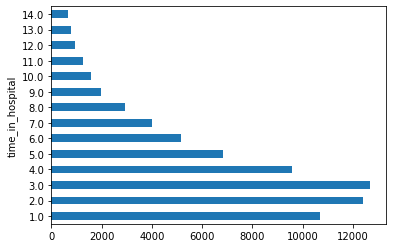

In [31]:
show_group_stats_viz(processed_df, PREDICTOR_FIELD)

time_in_hospital
1.0     6412
2.0     7355
3.0     7658
4.0     5785
5.0     4117
6.0     3127
7.0     2349
8.0     1783
9.0     1198
10.0     917
11.0     728
12.0     595
13.0     490
14.0     395
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


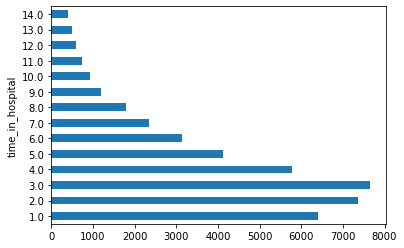

In [32]:
show_group_stats_viz(d_train, PREDICTOR_FIELD)

time_in_hospital
1.0     2131
2.0     2561
3.0     2535
4.0     1908
5.0     1384
6.0     1015
7.0      817
8.0      552
9.0      373
10.0     310
11.0     236
12.0     177
13.0     157
14.0     147
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


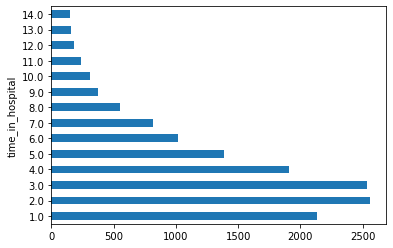

In [33]:
show_group_stats_viz(d_val, PREDICTOR_FIELD)

time_in_hospital
1.0     2172
2.0     2481
3.0     2508
4.0     1874
5.0     1338
6.0     1029
7.0      833
8.0      583
9.0      419
10.0     331
11.0     277
12.0     183
13.0     148
14.0     127
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


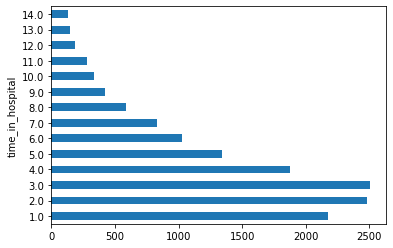

In [34]:
show_group_stats_viz(d_test, PREDICTOR_FIELD)

## Demographic Group Analysis

We should check that our partitions/splits of the dataset are similar in terms of their demographic profiles. Below you can see how we might visualize and analyze the full dataset vs. the partitions.

gender
Female    38025
Male      33490
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


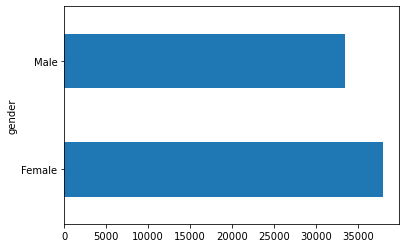

In [35]:
# Full dataset before splitting
patient_demo_features = ['race', 'gender', 'age', 'patient_nbr']
patient_group_analysis_df = processed_df[patient_demo_features].groupby('patient_nbr').head(1).reset_index(drop=True)
show_group_stats_viz(patient_group_analysis_df, 'gender')

gender
Female    22891
Male      20018
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


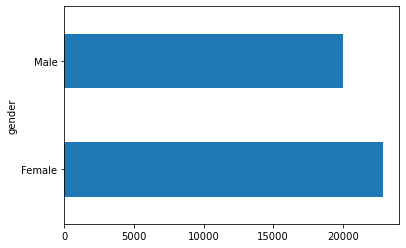

In [36]:
# Training partition
show_group_stats_viz(d_train, 'gender')

gender
Female    7613
Male      6690
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


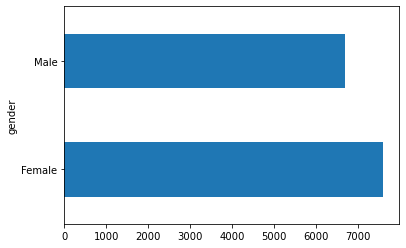

In [37]:
show_group_stats_viz(d_val, 'gender')

gender
Female    7521
Male      6782
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


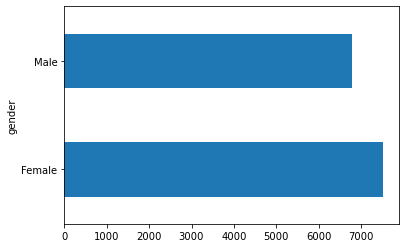

In [38]:
# Test partition
show_group_stats_viz(d_test, 'gender')

race
?                   1946
AfricanAmerican    12887
Asian                497
Caucasian          53491
Hispanic            1517
Other               1177
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


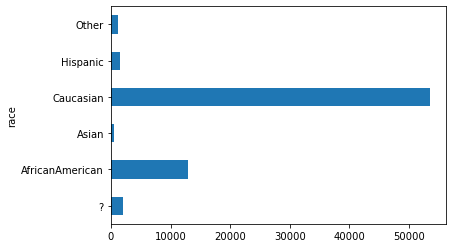

In [39]:
show_group_stats_viz(patient_group_analysis_df, 'race')

race
?                   1192
AfricanAmerican     7655
Asian                308
Caucasian          32139
Hispanic             895
Other                720
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


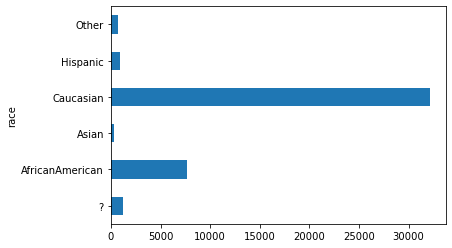

In [40]:
show_group_stats_viz(d_train, 'race')

race
?                    370
AfricanAmerican     2642
Asian                100
Caucasian          10634
Hispanic             328
Other                229
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


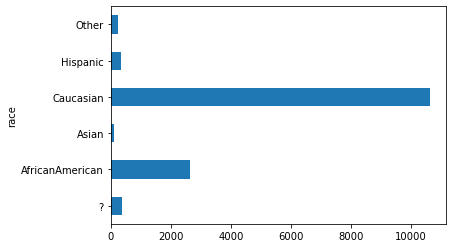

In [41]:
show_group_stats_viz(d_val, 'race')

race
?                    384
AfricanAmerican     2590
Asian                 89
Caucasian          10718
Hispanic             294
Other                228
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


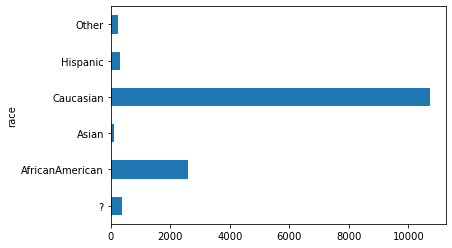

In [42]:
show_group_stats_viz(d_test, 'race')

age
[0-10)        154
[10-20)       535
[20-30)      1127
[30-40)      2699
[40-50)      6878
[50-60)     12466
[60-70)     15959
[70-80)     18208
[80-90)     11589
[90-100)     1900
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


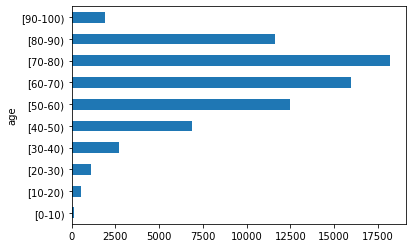

In [43]:
show_group_stats_viz(patient_group_analysis_df, 'age')

age
[0-10)         90
[10-20)       330
[20-30)       647
[30-40)      1616
[40-50)      4131
[50-60)      7496
[60-70)      9600
[70-80)     10857
[80-90)      7000
[90-100)     1142
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


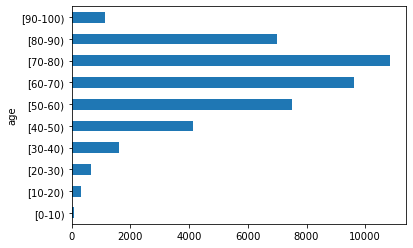

In [44]:
show_group_stats_viz(d_train, 'age')

age
[0-10)        31
[10-20)      102
[20-30)      238
[30-40)      536
[40-50)     1348
[50-60)     2476
[60-70)     3171
[70-80)     3727
[80-90)     2305
[90-100)     369
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


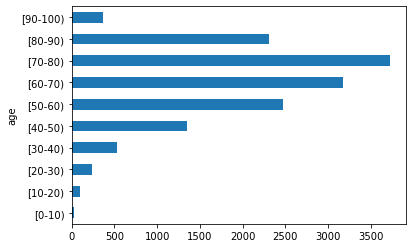

In [45]:
show_group_stats_viz(d_val, 'age')

age
[0-10)        33
[10-20)      103
[20-30)      242
[30-40)      547
[40-50)     1399
[50-60)     2494
[60-70)     3188
[70-80)     3624
[80-90)     2284
[90-100)     389
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


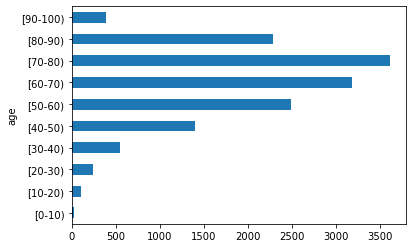

In [46]:
show_group_stats_viz(d_test, 'age')

## Convert Dataset Splits to TF Dataset

We have provided you the function to convert the Pandas dataframe to TF tensors using the TF Dataset API. 
Please note that this is not a scalable method and for larger datasets, the 'make_csv_dataset' method is recommended -https://www.tensorflow.org/api_docs/python/tf/data/experimental/make_csv_dataset.

In [47]:
# Convert dataset from Pandas dataframes to TF dataset 
batch_size = 128
diabetes_train_ds = df_to_dataset(d_train, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_val_ds = df_to_dataset(d_val, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_test_ds = df_to_dataset(d_test, PREDICTOR_FIELD, batch_size=batch_size)

In [48]:
# We use this sample of the dataset to show transformations later
diabetes_batch = next(iter(diabetes_train_ds))[0]
def demo(feature_column, example_batch):
    feature_layer = layers.DenseFeatures(feature_column)
    print(feature_layer(example_batch))

# 4. Create Categorical Features with TF Feature Columns

## Build Vocabulary for Categorical Features

Before we can create the TF categorical features, we must first create the vocab files with the unique values for a given field that are from the **training** dataset. Below we have provided a function that you can use that only requires providing the pandas train dataset partition and the list of the categorical columns in a list format. The output variable 'vocab_file_list' will be a list of the file paths that can be used in the next step for creating the categorical features.

In [49]:
vocab_file_list = build_vocab_files(df=d_train, categorical_column_list=student_categorical_col_list, default_value='00')

## Create Categorical Features with Tensorflow Feature Column API

**Question 7**: Using the vocab file list from above that was derived from the features you selected earlier, please create categorical features with the Tensorflow Feature Column API, https://www.tensorflow.org/api_docs/python/tf/feature_column. Below is a function to help guide you.

In [50]:
from student_utils import create_tf_categorical_feature_cols
tf_cat_col_list = create_tf_categorical_feature_cols(
    categorical_col_list=student_categorical_col_list, vocab_dir='./diabetes_vocab/'
)

INFO:tensorflow:vocabulary_size = 8 in admission_type_id is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/admission_type_id_vocab.txt.
INFO:tensorflow:vocabulary_size = 12 in admission_source_id is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/admission_source_id_vocab.txt.
INFO:tensorflow:vocabulary_size = 45 in medical_specialty is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/medical_specialty_vocab.txt.
INFO:tensorflow:vocabulary_size = 354 in primary_diagnosis_code is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/primary_diagnosis_code_vocab.txt.
INFO:tensorflow:vocabulary_size = 5 in max_glu_serum is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/max_glu_serum_vocab.txt.
INFO:tensorflow:vocabulary_size = 5 in A1Cresult is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/A1Cresult_vocab.txt.
INFO:tenso

In [51]:
test_cat_var1 = tf_cat_col_list[0]
print("Example categorical field:\n{}".format(test_cat_var1))
demo(test_cat_var1, diabetes_batch)

Example categorical field:
IndicatorColumn(categorical_column=VocabularyFileCategoricalColumn(key='admission_type_id', vocabulary_file='./diabetes_vocab/admission_type_id_vocab.txt', vocabulary_size=8, num_oov_buckets=1, dtype=tf.string, default_value=-1))

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

tf.Tensor(
[[0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]], shape=(128, 9), dtype=float32)


# 5. Create Numerical Features with TF Feature Columns

**Question 8**: Using the TF Feature Column API(https://www.tensorflow.org/api_docs/python/tf/feature_column/), please create normalized Tensorflow numeric features for the model. Try to use the z-score normalizer function below to help as well as the 'calculate_stats_from_train_data' function.

In [52]:
from student_utils import create_tf_numeric_feature

For simplicity the create_tf_numerical_feature_cols function below uses the same normalizer function across all features(z-score normalization) but if you have time feel free to analyze and adapt the normalizer based off the statistical distributions. You may find this as a good resource in determining which transformation fits best for the data https://developers.google.com/machine-learning/data-prep/transform/normalization.


In [53]:
def calculate_stats_from_train_data(df, col):
    mean = df[col].describe()['mean']
    std = df[col].describe()['std']
    return mean, std

def create_tf_numerical_feature_cols(numerical_col_list, train_df):
    tf_numeric_col_list = []
    for c in numerical_col_list:
        mean, std = calculate_stats_from_train_data(df=train_df, col=c)
        tf_numeric_feature = create_tf_numeric_feature(col=c, MEAN=mean, STD=std, default_value=0)
        tf_numeric_col_list.append(tf_numeric_feature)
    return tf_numeric_col_list

In [54]:
d_train['number_outpatient']

64949   -0.26201
29790   -0.26201
22359   -0.26201
37320   -0.26201
2786    -0.26201
          ...   
5541    -0.26201
28521    0.67347
33645   -0.26201
31885   -0.26201
55182   -0.26201
Name: number_outpatient, Length: 42909, dtype: float64

In [55]:
tf_cont_col_list = create_tf_numerical_feature_cols(student_numerical_col_list, d_train)

In [59]:
test_cont_var1 = tf_cont_col_list[0]
print("Example continuous field:\n{}\n".format(test_cont_var1))
demo(test_cont_var1, diabetes_batch)

Example continuous field:
NumericColumn(key='number_outpatient', shape=(1,), default_value=(0,), dtype=tf.float64, normalizer_fn=functools.partial(<function normalize_numeric_with_zscore at 0x7f101969aaf0>, mean=0.0006758460159410994, std=1.0053370353493931))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

tf.Tensor(
[[-0.2612916]
 [-0.2612916]
 [-0.2612916]
 [-0.2612916]
 [-0.2612916]
 [-0.2612916]
 [-0.2612916]
 [-0.2612916]
 [-0.2612916]
 [-0.2612916]
 [-0.2612916]
 [ 0.6692222]
 [-0.2612916]
 [-0.2612916]
 [-0.2612916]
 [-0.2612916]
 [-0.2612916

# 6. Build Deep Learning Regression Model with Sequential API and TF Probability Layers

## Use DenseFeatures to combine features for model

Now that we have prepared categorical and numerical features using Tensorflow's Feature Column API, we can combine them into a dense vector representation for the model. Below we will create this new input layer, which we will call 'claim_feature_layer'.

In [60]:
claim_feature_columns = tf_cat_col_list + tf_cont_col_list
claim_feature_layer = tf.keras.layers.DenseFeatures(claim_feature_columns)

In [61]:
for i in tf_cat_col_list:
    print(i.categorical_column.key)

admission_type_id
admission_source_id
medical_specialty
primary_diagnosis_code
max_glu_serum
A1Cresult
change
readmitted
race
gender
age
Acarbose
Glimepiride
Glipizide
Glyburide
Glyburide_And_Metformin_Hydrochloride
Glyburide-metformin_Hydrochloride
Human_Insulin
Insulin_Human
Metformin_Hcl
Metformin_Hydrochloride
Miglitol
Nateglinide
Pioglitazone
Pioglitazone_Hydrochloride_And_Glimepiride
Repaglinide
Rosiglitazone_Maleate
Tolazamide
Tolbutamide


In [62]:
for i in tf_cont_col_list:
    print(i.key)

number_outpatient
number_inpatient
number_emergency
num_lab_procedures
number_diagnoses
num_medications
num_procedures


## Build Sequential API Model from DenseFeatures and TF Probability Layers

Below we have provided some boilerplate code for building a model that connects the Sequential API, DenseFeatures, and Tensorflow Probability layers into a deep learning model. There are many opportunities to further optimize and explore different architectures through benchmarking and testing approaches in various research papers, loss and evaluation metrics, learning curves, hyperparameter tuning, TF probability layers, etc. Feel free to modify and explore as you wish.

**OPTIONAL**: Come up with a more optimal neural network architecture and hyperparameters. Share the process in discovering the architecture and hyperparameters.

In [63]:
def build_sequential_model(feature_layer):
    model = tf.keras.Sequential([
        feature_layer,
#         tf.keras.layers.Dense(150, activation='relu'),
#         tf.keras.layers.Dense(75, activation='relu'),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(150, activation='relu'),
        tf.keras.layers.Dense(75, activation='relu'),
        tfp.layers.DenseVariational(1+1, posterior_mean_field, prior_trainable),
        tfp.layers.DistributionLambda(
            lambda t:tfp.distributions.Normal(
                loc=t[..., :1],
                scale=1e-3 + tf.math.softplus(0.01 * t[...,1:])
            )
        ),
    ])
    return model

def build_diabetes_model(train_ds, val_ds, feature_layer, epochs=5, loss_metric='mse'):
    model = build_sequential_model(feature_layer=feature_layer)
    # optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01, rho=0.9, momentum=0.0, epsilon=1e-07)
    model.compile(optimizer=optimizer, loss=loss_metric, metrics=[loss_metric])
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    cb_reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.2, patience=5, min_lr=1e-7)
    history = model.fit(train_ds,
                        validation_data=val_ds,
                        callbacks=[cb_reduce_lr, early_stop],
                        epochs=epochs)
    return model, history 

In [64]:
diabetes_model, history = build_diabetes_model(
    train_ds=diabetes_train_ds,
    val_ds=diabetes_val_ds,
    feature_layer=claim_feature_layer,
    epochs=1000,
    loss_metric='mse'
)

Epoch 1/1000

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

336/336 [==============================] - 5s 15ms/step - loss: 17532.9668 - mse: 17531.5918 - val_loss: 15.3189 - val_mse: 13.1431 - lr: 0.0100
Epoch 2/1000
336/336 [==============================] - 4s 13ms/step - loss: 17.8834 - mse: 15.8847 - val_loss: 11.2384 - val_mse: 9.0260 - lr: 0.0100
Epoch 3/1000
336/336 [==============================] - 4s 13ms/step - loss: 10.9699 - mse: 8.7777 - val_loss: 9.3213 - val_mse: 7.3214 - lr: 0.0100
Epoch 4/1000
336/336 [============================

In [65]:
diabetes_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_features_2 (DenseFeatu multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  561152    
_________________________________________________________________
dense_1 (Dense)              multiple                  524800    
_________________________________________________________________
dense_2 (Dense)              multiple                  131328    
_________________________________________________________________
dense_3 (Dense)              multiple                  38550     
_________________________________________________________________
dense_4 (Dense)              multiple                  11325     
_________________________________________________________________
dense_variational (DenseVari multiple                  4

In [66]:
diabetes_model.evaluate(diabetes_test_ds)

112/112 [==============================] - 1s 8ms/step - loss: 7.5820 - mse: 6.1739


[7.581958293914795, 6.173942565917969]

## Show Model Uncertainty Range with TF Probability

**Question 9**: Now that we have trained a model with TF Probability layers, we can extract the mean and standard deviation for each prediction. Please fill in the answer for the m and s variables below. The code for getting the predictions is provided for you below.

In [67]:
feature_list = student_categorical_col_list + student_numerical_col_list
diabetes_x_tst = dict(d_test[feature_list])
diabetes_yhat = diabetes_model(diabetes_x_tst)
preds = diabetes_model.predict(diabetes_test_ds)

In [68]:
from student_utils import get_mean_std_from_preds
m, s = get_mean_std_from_preds(diabetes_yhat)

## Show Prediction Output 

In [69]:
prob_outputs = {
    "pred": preds.flatten(),
    "actual_value": d_test['time_in_hospital'].values,
    "pred_mean": m.numpy().flatten(),
    "pred_std": s.numpy().flatten()
}
prob_output_df = pd.DataFrame(prob_outputs)

In [70]:
prob_output_df.head()

,pred,actual_value,pred_mean,pred_std
0,5.653368,7.0,4.990380,0.700684
1,0.934730,7.0,4.297174,0.701269
2,1.045936,5.0,4.900698,0.700719
3,0.106014,6.0,4.556041,0.701033
4,1.616724,11.0,8.543819,0.699120


## Convert Regression Output to Classification Output for Patient Selection

**Question 10**: Given the output predictions, convert it to a binary label for whether the patient meets the time criteria or does not (HINT: use the mean prediction numpy array). The expected output is a numpy array with a 1 or 0 based off if the prediction meets or doesnt meet the criteria.

In [71]:
(prob_output_df['pred_mean']>5).astype(int)

0        0
1        0
2        0
3        0
4        1
        ..
14298    0
14299    0
14300    0
14301    1
14302    1
Name: pred_mean, Length: 14303, dtype: int64

In [72]:
from student_utils import get_student_binary_prediction
student_binary_prediction = get_student_binary_prediction(prob_output_df, 'pred_mean')

### Add Binary Prediction to Test Dataframe

Using the student_binary_prediction output that is a numpy array with binary labels, we can use this to add to a dataframe to better visualize and also to prepare the data for the Aequitas toolkit. The Aequitas toolkit requires that the predictions be mapped to a binary label for the predictions (called 'score' field) and the actual value (called 'label_value').

In [73]:
def add_pred_to_test(test_df, pred_np, demo_col_list):
    for c in demo_col_list:
        test_df[c] = test_df[c].astype(str)
    test_df['score'] = pred_np
    test_df['label_value'] = test_df['time_in_hospital'].apply(lambda x: 1 if x >=5 else 0)
    return test_df

pred_test_df = add_pred_to_test(d_test, student_binary_prediction, ['race', 'gender'])

<ipython-input-73-f592ba0c0993>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[c] = test_df[c].astype(str)
<ipython-input-73-f592ba0c0993>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['score'] = pred_np
<ipython-input-73-f592ba0c0993>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

In [74]:
pred_test_df[['patient_nbr', 'gender', 'race', 'time_in_hospital', 'score', 'label_value']]

,patient_nbr,gender,race,time_in_hospital,score,label_value
5,77391171,Male,AfricanAmerican,7.0,1.0,1
6,85504905,Female,Caucasian,7.0,0.0,1
15,107389323,Male,AfricanAmerican,5.0,0.0,1
16,69422211,Male,?,6.0,0.0,1
21,107400762,Female,Caucasian,11.0,0.0,1
...,...,...,...,...,...,...
71494,106722468,Female,Caucasian,6.0,NaN,1
71496,98476776,Male,Caucasian,3.0,NaN,0
71501,38726739,Female,AfricanAmerican,3.0,NaN,0
71510,175326800,Male,Caucasian,13.0,NaN,1


In [75]:
pred_test_df['score'].value_counts(dropna=False)

NaN    11470
0.0     1938
1.0      895
Name: score, dtype: int64

## Model Evaluation Metrics 

**Question 11**: Now it is time to use the newly created binary labels in the 'pred_test_df' dataframe to evaluate the model with some common classification metrics. Please create a report summary of the performance of the model and be sure to give the ROC AUC, F1 score(weighted), class precision and recall scores. 

For the report please be sure to include the following three parts:
- With a non-technical audience in mind, explain the precision-recall tradeoff in regard to how you have optimized your model.

- What are some areas of improvement for future iterations?







For the first question you need to answer what exactly is the Precision-Recall Tradeoff. As you may already be knowing Precision tells us of all the data points predicted as positive by the model how many of them were actually positive. Similarly Recall tells us, of all the data points actually positive how many of them were predicted correctly by the model. Also as we try to increase the value of precision by changing the threshold value for prediction, Recall suffers.You need to explain these metrics in simple words.Please do consider adding which evaluation metric would be important for this particular case study. Is it Precision or Recall ?

For the second question you need to explain the ways of improving your models. Here you can talk about trying out different model architectures, optimizers, learning rates etc which can boost your precision, recall, accuracy, roc score.For eg you can add some regularization which can prevent overfitting and make your model more robust.

In [76]:
pred_test_df['score'].fillna(0, inplace=True)

/home/ud/miniconda3/envs/py38ml/lib/python3.8/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [77]:
# AUC, F1, precision and recall
# Summary
print(sklearn.metrics.classification_report(pred_test_df['label_value'], pred_test_df['score']))

              precision    recall  f1-score   support

           0       0.63      0.94      0.76      9035
           1       0.40      0.07      0.12      5268

    accuracy                           0.62     14303
   macro avg       0.52      0.50      0.44     14303
weighted avg       0.55      0.62      0.52     14303



In [78]:
sklearn.metrics.brier_score_loss(pred_test_df['label_value'], pred_test_df['score'])

0.3812486890862057

In [79]:
sklearn.metrics.roc_auc_score(pred_test_df['label_value'], pred_test_df['score'])

0.5038102162391341

In [80]:
pred_test_df

,patient_nbr,time_in_hospital,admission_type_id,admission_source_id,medical_specialty,primary_diagnosis_code,max_glu_serum,A1Cresult,change,readmitted,race,gender,age,Acarbose,Glimepiride,Glipizide,Glyburide,Glyburide_And_Metformin_Hydrochloride,Glyburide-metformin_Hydrochloride,Human_Insulin,Insulin_Human,Metformin_Hcl,Metformin_Hydrochloride,Miglitol,Nateglinide,Pioglitazone,Pioglitazone_Hydrochloride_And_Glimepiride,Repaglinide,Rosiglitazone_Maleate,Tolazamide,Tolbutamide,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,score,label_value
5,77391171,7.0,2,4,?,157,None,None,Ch,<30,AfricanAmerican,Male,[60-70),0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.262010,-0.294531,-0.203351,0.948483,-0.123207,-0.566107,-0.812874,1.0,1
6,85504905,7.0,1,7,Family/GeneralPractice,428,None,None,Ch,<30,Caucasian,Female,[40-50),0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.262010,-0.294531,1.760540,0.848242,0.378138,-0.084826,-0.812874,0.0,1
15,107389323,5.0,1,7,?,402,None,None,No,>30,AfricanAmerican,Male,[70-80),0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.262010,-0.294531,-0.203351,-0.404764,0.879482,0.877737,2.028300,0.0,1
16,69422211,6.0,3,2,?,?,None,None,Ch,NO,?,Male,[70-80),0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.262010,-0.294531,-0.203351,-0.053922,0.378138,0.877737,0.323595,0.0,1
21,107400762,11.0,2,1,?,V57,None,None,No,>30,Caucasian,Female,[80-90),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.262010,-0.294531,-0.203351,-0.053922,0.378138,0.396456,0.323595,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71494,106722468,6.0,1,7,?,599,None,None,Ch,NO,Caucasian,Female,[70-80),0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.157309,-0.294531,-0.203351,-0.154163,0.879482,0.276135,-0.244639,0.0,1
71496,98476776,3.0,3,1,?,715,None,None,No,>30,Caucasian,Male,[60-70),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.262010,-0.294531,-0.203351,-0.104043,-0.123207,-0.325467,-0.244639,0.0,0
71501,38726739,3.0,1,7,?,786,None,None,No,NO,AfricanAmerican,Female,[70-80),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.262010,1.361655,-0.203351,0.697882,0.879482,-0.566107,1.460065,0.0,0
71510,175326800,13.0,3,1,?,424,None,Norm,Ch,NO,Caucasian,Male,[70-80),0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.262010,-0.294531,-0.203351,1.700287,4.388893,5.931194,2.596535,0.0,1


In [81]:
tn, fp, fn, tp = sklearn.metrics.confusion_matrix(
    y_true=pred_test_df['score'], y_pred=pred_test_df['label_value'], labels=None,
    sample_weight=None, normalize=None
).ravel()


In [82]:
import seaborn as sns

In [83]:
def plot_confusion_matrix(tp, tn, fp, fn):
    """
    
    """
    df_cm = pd.DataFrame([[tn,fp], [fn, tp]], index=range(2), columns=range(2))
    sns.set(font_scale=1.4) # for label size
    ax = sns.heatmap(df_cm, annot=True, annot_kws={"size": 14}, fmt="d") # font size
    _ = ax.set(xlabel='predictions', ylabel='labels', title='Confusion matrix')
    return ax

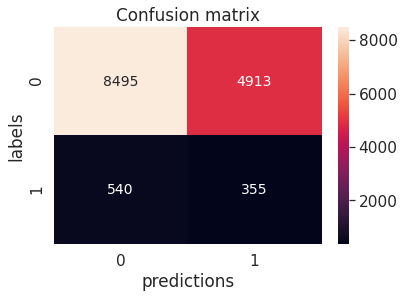

In [84]:
plot_confusion_matrix(tp, tn, fp, fn)

# 7. Evaluating Potential Model Biases with Aequitas Toolkit

## Prepare Data For Aequitas Bias Toolkit 

Using the gender and race fields, we will prepare the data for the Aequitas Toolkit.

In [85]:
# Aequitas
from aequitas.preprocessing import preprocess_input_df
from aequitas.group import Group
from aequitas.plotting import Plot
from aequitas.bias import Bias
from aequitas.fairness import Fairness

ae_subset_df = pred_test_df[['race', 'gender', 'score', 'label_value']]
ae_df, _ = preprocess_input_df(ae_subset_df)
g = Group()
xtab, _ = g.get_crosstabs(ae_df)
absolute_metrics = g.list_absolute_metrics(xtab)
clean_xtab = xtab.fillna(-1)
aqp = Plot()
b = Bias()

model_id, score_thresholds 1 {'rank_abs': [895]}


/home/ud/miniconda3/envs/py38ml/lib/python3.8/site-packages/aequitas/group.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] = df['score'].astype(float)


## Reference Group Selection

Below we have chosen the reference group for our analysis but feel free to select another one.

In [86]:
# test reference group with Caucasian Male
bdf = b.get_disparity_predefined_groups(
    clean_xtab, 
    original_df=ae_df,
    ref_groups_dict={'race':'Caucasian', 'gender':'Male'}, 
    alpha=0.05,
    check_significance=False
)

f = Fairness()
fdf = f.get_group_value_fairness(bdf)

get_disparity_predefined_group()


/home/ud/miniconda3/envs/py38ml/lib/python3.8/site-packages/aequitas/bias.py:368: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  df = df.replace(pd.np.inf, fill_divbyzero)
/home/ud/miniconda3/envs/py38ml/lib/python3.8/site-packages/aequitas/fairness.py:32: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  self.fair_eval = lambda tau: lambda x: pd.np.nan if pd.np.isnan(x) else \
/home/ud/miniconda3/envs/py38ml/lib/python3.8/site-packages/aequitas/fairness.py:45: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  self.high_level_pair_eval = lambda col1, col2: lambda x: pd.np.nan if (pd.np.isnan(x[col1]) and pd.np.isnan(x[col2])) \


In [87]:
fdf

,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity,ppr_ref_group_value,pprev_ref_group_value,precision_ref_group_value,fdr_ref_group_value,for_ref_group_value,fpr_ref_group_value,fnr_ref_group_value,tpr_ref_group_value,tnr_ref_group_value,npv_ref_group_value,Statistical Parity,Impact Parity,FDR Parity,FPR Parity,FOR Parity,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,1,binary 0/1,895,race,?,0.042254,0.958678,0.369565,0.625000,0.041322,0.957746,0.630435,0.375000,16,368,0.017877,0.041667,10,136,232,6,142,242,384,14303,0.369792,0.023810,0.664559,0.929889,1.047382,1.012449,0.698667,1.028526,0.614001,1.018943,0.992843,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,False,False,True,False,True,True,False,True,True,True,False,True,False,False,False
1,1,binary 0/1,895,race,AfricanAmerican,0.072671,0.939864,0.374071,0.577381,0.060136,0.927329,0.625929,0.422619,168,2422,0.187709,0.064865,97,906,1516,71,977,1613,2590,14303,0.377220,0.250000,1.034556,1.047970,0.967581,1.024793,1.016770,0.995860,1.056015,0.998946,0.985747,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,False,True,True,True,True,True,True,True,True,True,True,True,True,False,True
2,1,binary 0/1,895,race,Asian,0.000000,0.949153,0.348837,1.000000,0.050847,1.000000,0.651163,0.000000,3,86,0.003352,0.033708,3,30,56,0,30,59,89,14303,0.337079,0.004464,0.537620,0.000000,1.675810,0.955664,0.859715,1.073902,0.000000,1.008819,1.025487,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,False,False,False,True,True,True,False,True,True,False,False,True,False,False,False
3,1,binary 0/1,895,race,Caucasian,0.068817,0.940855,0.365021,0.596726,0.059145,0.931183,0.634979,0.403274,672,10046,0.750838,0.062698,401,3667,6379,271,3938,6780,10718,14303,0.367419,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
4,1,binary 0/1,895,race,Hispanic,0.029126,0.890052,0.370370,0.875000,0.109948,0.970874,0.629630,0.125000,24,270,0.026816,0.081633,21,100,170,3,103,191,294,14303,0.350340,0.035714,1.301992,0.309963,1.466334,1.014655,1.858965,1.042624,0.423244,0.946003,0.991575,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,False,False,False,False,True,True,False,True,True,False,False,True,False,False,False
5,1,binary 0/1,895,race,Other,0.051282,0.946667,0.342593,0.666667,0.053333,0.948718,0.657407,0.333333,12,216,0.013408,0.052632,8,74,142,4,78,150,228,14303,0.342105,0.017857,0.839442,0.826568,1.117207,0.938556,0.901746,1.018830,0.745198,1.006177,1.035321,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,False,True,True,True,True,True,False,True,True,True,True,True,False,False,True
6,1,binary 0/1,895,gender,Female,0.067069,0.941101,0.372644,0.594421,0.058899,0.932931,0.627356,0.405579,466,7055,0.520670,0.061960,277,2629,4426,189,2818,4703,7521,14303,0.374684,1.086247,0.979514,1.048154,0.969606,1.036517,0.970147,1.000736,0.989871,1.001930,0.979503,Male,Male,Male,Male,Male,Male,Male,Male,Male,Male,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
7,1,binary 0/1,895,gender,Male,0.067755,0.939289,0.359515,0.613054,0.060711,0.932245,0.640485,0.386946,429,6353,0.479330,0.063256,263,2284,4069,166,2450,4332,6782,14303,0.361250,1.000000,1.000000,1.000000,

## Race and Gender Bias Analysis for Patient Selection

**Question 12**: For the gender and race fields, please plot two metrics that are important for patient selection below and state whether there is a significant bias in your model across any of the groups along with justification for your statement.

In [88]:
# Plot two metrics

# Is there significant bias in your model for either race or gender?

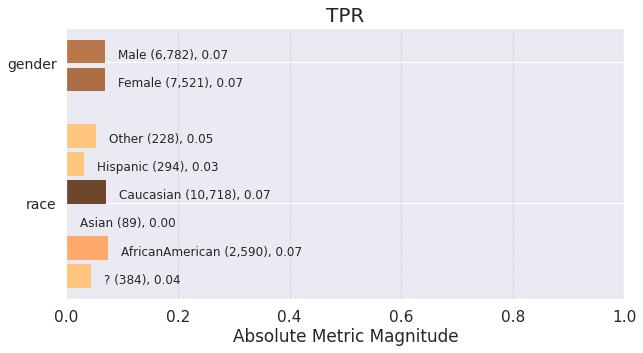

In [89]:
tpr = aqp.plot_group_metric(clean_xtab, 'tpr', min_group_size=0.00)

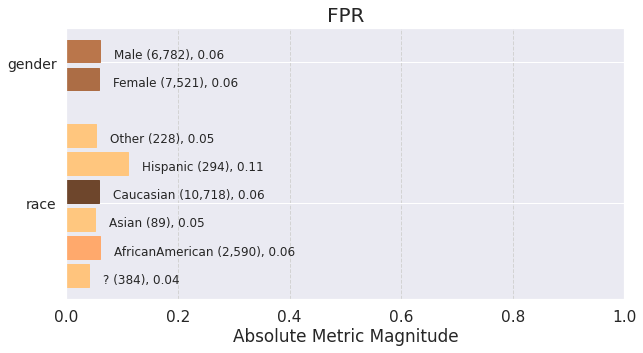

In [90]:
fpr = aqp.plot_group_metric(clean_xtab, 'fpr', min_group_size=0.00)

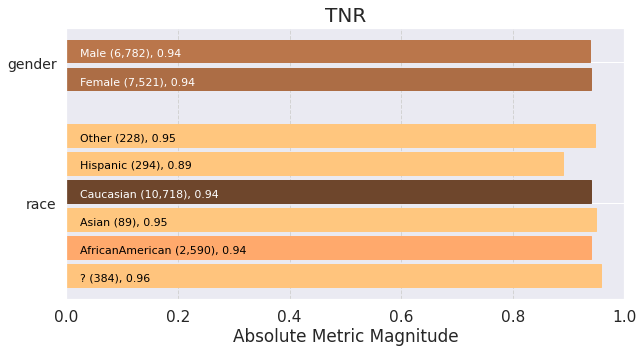

In [91]:
tnr = aqp.plot_group_metric(clean_xtab, 'tnr', min_group_size=0.00)

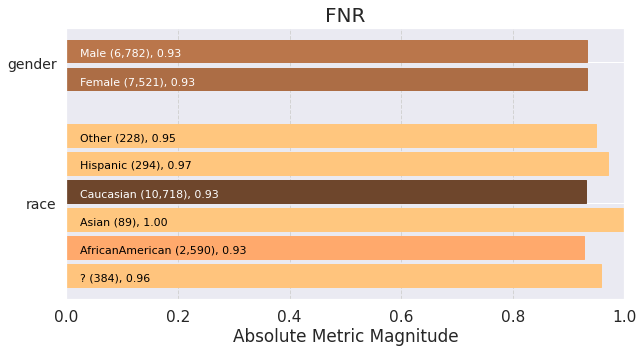

In [92]:
fnr = aqp.plot_group_metric(clean_xtab, 'fnr', min_group_size=0.00)

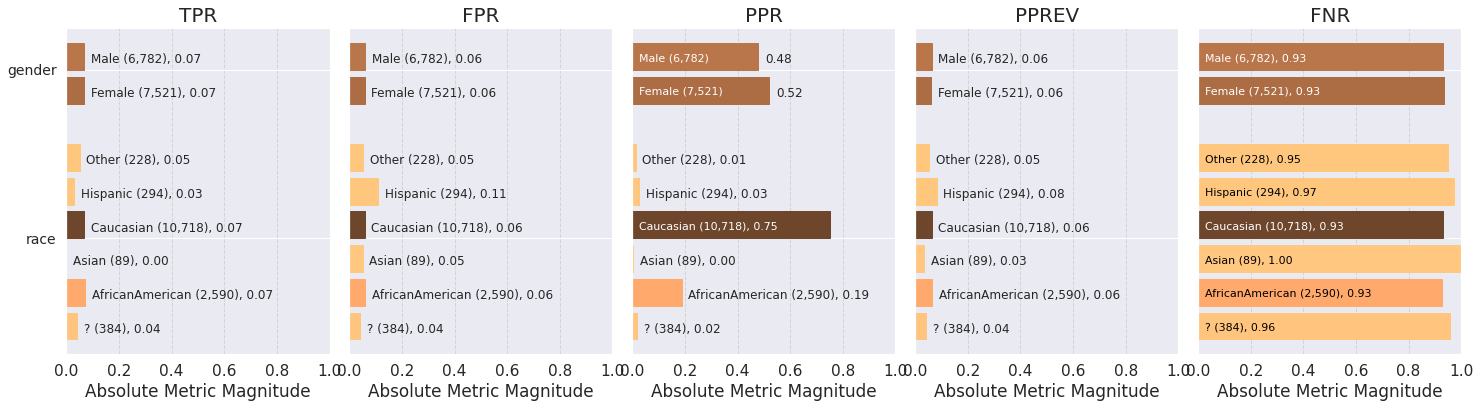

In [93]:
p = aqp.plot_group_metric_all(clean_xtab, metrics=['tpr', 'fpr', 'ppr', 'pprev', 'fnr'], ncols=5)

False Negative Rate (FNR) means the proportion of tests that indicate no disease, but actually have the disease.

Using Caucasian population as base, we see that Asian population has higher FNR, which means the test is less likely to detect diseases in the Asian population.

This could be problematic if used uniformly for diagnosis on the entire population.

## Fairness Analysis Example - Relative to a Reference Group 

**Question 13**: Earlier we defined our reference group and then calculated disparity metrics relative to this grouping. Please provide a visualization of the fairness evaluation for this reference group and analyze whether there is disparity.

In [94]:
# Reference group fairness plot

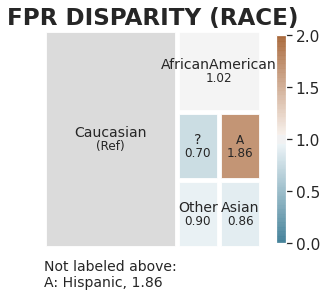

In [95]:
fpr_disparity = aqp.plot_disparity(bdf, group_metric='fpr_disparity', attribute_name='race')

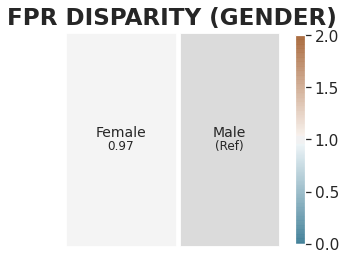

In [96]:
fpr_disparity = aqp.plot_disparity(bdf, group_metric='fpr_disparity', attribute_name='gender')

Absolute Value Fairness Determination:
    
- Red = False/Not Fair
- Green = True/Fair

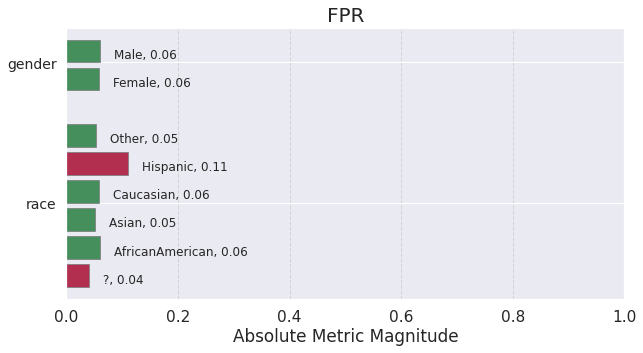

In [97]:
fpr_fairness = aqp.plot_fairness_group(fdf, group_metric='fpr', title=True)